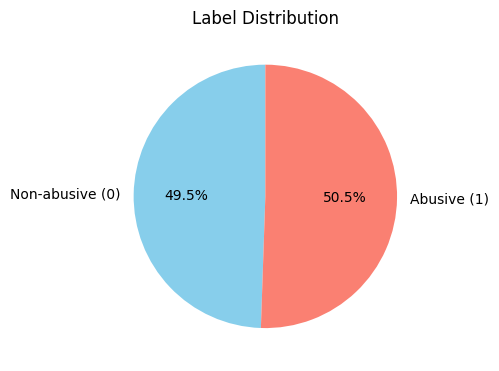

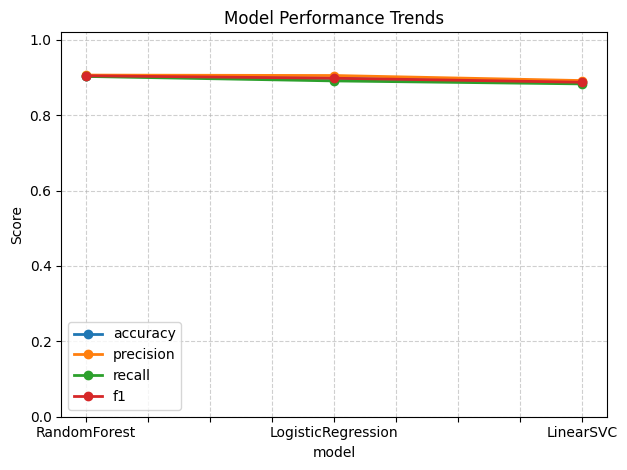

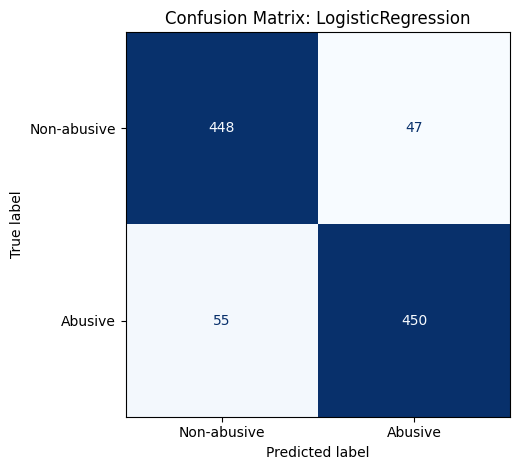

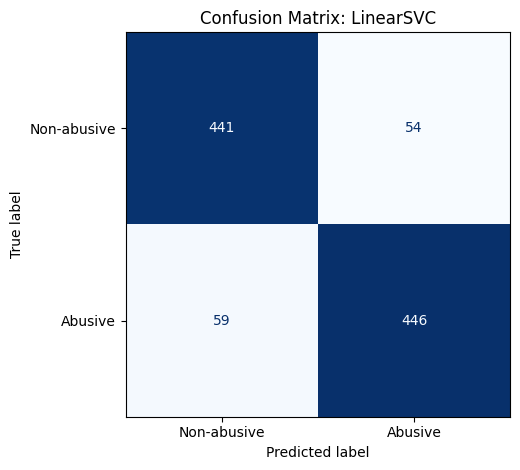

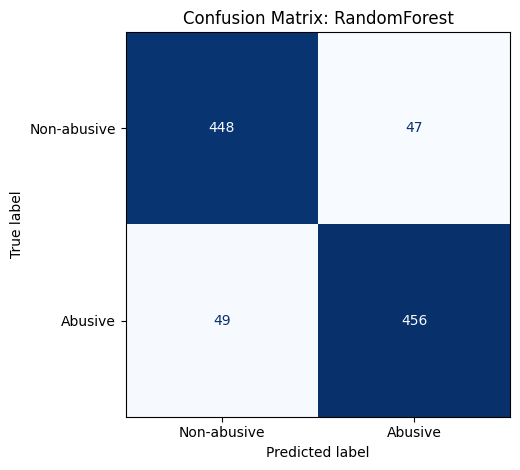

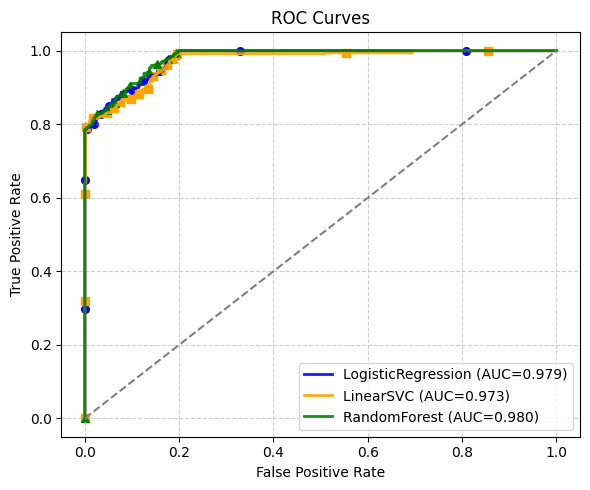

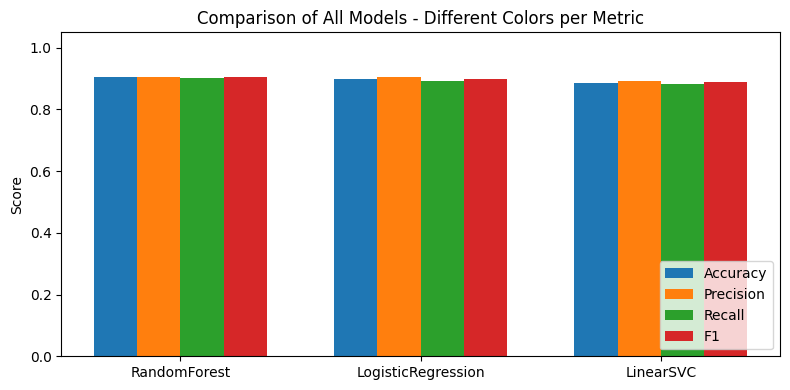

Samples: 5000
Label counts: {1: 2527, 0: 2473}

Results:
              model  accuracy  precision   recall       f1      auc
      RandomForest     0.904   0.906561 0.902970 0.904762 0.980320
LogisticRegression     0.898   0.905433 0.891089 0.898204 0.978506
         LinearSVC     0.887   0.892000 0.883168 0.887562 0.972649


In [ ]:
#     Cyberbullying Detection Benchmarking

import pandas as pd, numpy as np, re, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
)
from sklearn.calibration import CalibratedClassifierCV

# ---------------- Part 1: Loading & Cleaning of Dataset ----------------
def load_and_clean(file_path):
    df = pd.read_csv(file_path, sep=";")
    df = df.drop(columns=[c for c in ["name", "email"] if c in df.columns])  # remove PII
    df["user_id"] = pd.to_numeric(df["user_id"], errors="coerce")
    df = df.dropna(subset=["user_id"])
    df["user_id"] = df["user_id"].astype(int)
    return df

# ---------------- Part 2: Preprocess of Text ----------------
stop_words = {"the","and","is","in","to","of","a","i","it","for","you","that",
              "on","with","this","was","are","be","not","have","as","but","or",
              "they","we","he","she"}

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = [w for w in text.split() if w not in stop_words and len(w) > 1]
    return " ".join(tokens)

def add_clean_text(df):
    df["clean_text"] = df["comment_text"].apply(preprocess_text)
    return df

# ---------------- Part 3: Split Data ----------------
def split_data(df, test_size=0.2):
    X = df["clean_text"].values
    y = df["cyberbullying"].astype(int).values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    return X_train, X_test, y_train, y_test

# ---------------- Part 4: TF-IDF Vectorization ----------------
def vectorize_text(X_train, X_test, max_features=1500):
    tfidf = TfidfVectorizer(max_features=max_features, ngram_range=(1,1))
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    return X_train_tfidf, X_test_tfidf

# ---------------- Part 5: Train Models & Compute Metrics of LR,SVC,RF ----------------
def train_and_evaluate(X_train_tfidf, X_test_tfidf, y_train, y_test):
    models = {
        "LogisticRegression": LogisticRegression(max_iter=2000, random_state=42),
        "LinearSVC": SVC(kernel='linear', max_iter=20000, probability=True, random_state=42),
        "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42)
    }

    results, conf_matrices, roc_data = {}, {}, {}

    for name, model in models.items():
        if name == "LinearSVC":
            model = CalibratedClassifierCV(model)

        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_test_tfidf)

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        conf_matrices[name] = cm

        # ROC curves
        y_prob = model.predict_proba(X_test_tfidf)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        roc_data[name] = (fpr, tpr, roc_auc)

        results[name] = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, zero_division=0),
            "recall": recall_score(y_test, y_pred, zero_division=0),
            "f1": f1_score(y_test, y_pred, zero_division=0),
            "auc": roc_auc
        }

    results_df = pd.DataFrame(results).T.reset_index().rename(columns={"index":"model"})
    results_df = results_df.sort_values("f1", ascending=False)

    return results_df, conf_matrices, roc_data

# ---------------- Part 6: Visualization ----------------
def visualize_results(df, results_df, conf_matrices, roc_data):
    # Pie chart
    counts = df["cyberbullying"].value_counts().sort_index()
    plt.figure(figsize=(5,5))
    plt.pie(counts.values, labels=['Non-abusive (0)','Abusive (1)'],
            autopct='%1.1f%%', colors=["skyblue","salmon"], startangle=90)
    plt.title("Label Distribution")
    plt.tight_layout()
    plt.show()

    # KPI line plot
    results_df.set_index("model")[["accuracy","precision","recall","f1"]].plot(marker="o", linewidth=2)
    plt.ylim(0,1.02)
    plt.ylabel("Score")
    plt.title("Model Performance Trends")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    # Confusion matrices
    for name, cm in conf_matrices.items():
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-abusive","Abusive"])
        disp.plot(cmap="Blues", colorbar=False)
        plt.title(f"Confusion Matrix: {name}")
        plt.tight_layout()
        plt.show()

    # ROC curves
    plt.figure(figsize=(6,5))
    colors = ["blue","orange","green"]
    markers = ["o","s","^"]
    for i, (name, (fpr, tpr, roc_auc)) in enumerate(roc_data.items()):
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})", color=colors[i], linewidth=2, alpha=0.9)
        plt.scatter(fpr[::10], tpr[::10], color=colors[i], marker=markers[i], s=30)
    plt.plot([0,1], [0,1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    # Combined KPI comparison
    plt.figure(figsize=(8,4))
    x = np.arange(len(results_df))
    width = 0.18
    metric_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
    for i, metric in enumerate(["accuracy","precision","recall","f1"]):
        plt.bar(x + (i-1.5)*width, results_df[metric], width, color=metric_colors[i], label=metric.capitalize())
    plt.xticks(x, results_df["model"])
    plt.ylim(0,1.05)
    plt.ylabel("Score")
    plt.title("Comparison of All Models - Different Colors per Metric")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# ---------------- Part 7: Main Execution ----------------
if __name__ == "__main__":
    df = load_and_clean("/content/Cyberbullying_5000_noisy (1).csv")
    df = add_clean_text(df)
    X_train, X_test, y_train, y_test = split_data(df)
    X_train_tfidf, X_test_tfidf = vectorize_text(X_train, X_test)
    results_df, conf_matrices, roc_data = train_and_evaluate(X_train_tfidf, X_test_tfidf, y_train, y_test)

    # Save results
    results_df.to_csv("benchmark_results_real.csv", index=False)

    visualize_results(df, results_df, conf_matrices, roc_data)

    # Print summary
    print("Samples:", df.shape[0])
    print("Label counts:", df["cyberbullying"].value_counts().to_dict())
    print("\nResults:\n", results_df.to_string(index=False))